In [1]:
# manipula arrays e arrays matriciais
import numpy as np

# data processing
import pandas as pd

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn.tree import DecisionTreeClassifier

# Conhecimento do domínio

Informações gerais do dataset: https://www.kaggle.com/competitions/titanic

Em 15 de abril de 1912 o RMS Titanic realizava sua viagem de cruzeiro sobre o atlântico norte até que colide com um iceberg, que resulta na morte de 1502 das 2224 pessoas dentre elas passageiros e tripulantes.

Problema: Não haviam botes salva vidas para todos no navio, por isso, queremos encontrar que tipo de pessoa no Titanic tem mais probabilidade de sobrevivência com base em Idade, Sexo, Classe socio econômica, Se tinha parentes, familiares e se havia sido registrado o embarque.

Para avaliar o desempenho do algorítmo seguiremos um método de avaliação iterativo que consiste em:
1. Pegar uma base de dados do mundo real;
2. Separar a base de dados em conjunto de treino e conjunto de teste;
3. Configurar diferentes hiperparâmetros (4) para o modelo e dar como entrada a base de treino para criação de uma hipótese h;
4. Avaliar a porcentagem de exemplos de treino que são corretamente classificados pela hipótese h gerada;
5. (EXTRA) Comparar a hipotese h gerada com as outras 4 geradas pelos diferentes hiperparâmetros configurados no modelo.

In [4]:
from zipfile import ZipFile
zip_file = ZipFile('./data/titanic.zip')

data_train = pd.read_csv(zip_file.open('train.csv'))
data_test = pd.read_csv(zip_file.open('test.csv'))
data_gender = pd.read_csv(zip_file.open('gender_submission.csv'))

# Pré - Processamento

Nessa etapa, vamos análisar todo o dataset disponibilizado para limpar, transformar, formatar, selecionar e extrair descrições de dados, ou seja, nós preparamos os dados do dataset para fazer a Extração de Padrões. A ideia do preparo é identificar valores faltantes, outliers e inconsistências.

Obs: Outlier são anomalias nos conjuntos que fazem com que pontos de dados fiquem muito distantes do restante, podendo distorcer an análises estatísticas e os modelos de aprendizado de máquina.

In [5]:
data_train.head(5) # olhada rápida nas colunas

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Vamos iniciar com uma análise mais geral dos dados considerando o dicionário de variáveis proxy do dataset.

**pclass:** Um intermédio para status sócio-econômico (SSE):
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

Ao observar os valores do output, percebemos que o SSE é inteiro e não descrito por string

In [6]:
print(data_train["Pclass"])
print("Null: ", data_train["Pclass"].isnull().sum())
print("NaN: ", data_train["Pclass"].isna().sum())

0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: Pclass, Length: 891, dtype: int64
Null:  0
NaN:  0


**age:** Idade fracionária se menor que 1. Se for estimada, tem a forma xx.5.


Aqui já identificamos um problema, temos valores ausentes na coluna de idade, uma variável importante para nosso estudo e que se continuar assim, pode afetar negativamente o desempenho do nosso modelo.

In [7]:
print(data_train["Age"])
print("Null: ", data_train["Age"].isnull().sum())
print("NaN: ", data_train["Age"].isna().sum())

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64
Null:  177
NaN:  177



**sibsp:** O dataset define relações familiares da forma:
- Sibling = irmão, irmã, meio irmão, meia irmã
- Spouse = marido, esposa (amantes e noivos(as) foram ignorados)

Ao observar os valores do output, percebemos que os laços são contados e não descritos por string

In [8]:
print(data_train["SibSp"])
print("Null: ", data_train["SibSp"].isnull().sum())
print("NaN: ", data_train["SibSp"].isna().sum())

0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    1
889    0
890    0
Name: SibSp, Length: 891, dtype: int64
Null:  0
NaN:  0


**parch:** O dataset define relações familiares da forma:
Parent = mãe, pai
Child = filha, filho, enteada, enteado
Algumas crianças viajaram apenas com a babá, portanto parch=0 para eles.

In [9]:
print(data_train["Parch"])
print("Null: ", data_train["Parch"].isnull().sum())
print("NaN: ", data_train["Parch"].isna().sum())

0      0
1      0
2      0
3      0
4      0
      ..
886    0
887    0
888    2
889    0
890    0
Name: Parch, Length: 891, dtype: int64
Null:  0
NaN:  0


Perceba que das variáveis descritas pelo dicionário, apenas Age continha valores NaN, mas não sabemos quanto as outras que não foram verificadas. Podemos utilizar o método isnull() para todo o dataset.

In [10]:
data_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Ao observar Cabin, percebemos que alguns passageiros possuíam um quarto associado ao seu id, isso pode sugerir que os passageiros NaN dormiam no convés e tinham uma acomodação menos luxuosa e por isso não havia distinção de cabine.

In [11]:
print(data_train["Cabin"])
result = data_train[data_train["Cabin"].isnull() & (data_train["Pclass"] == 3)]
print(result)

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object
     PassengerId  Survived  Pclass                                      Name  \
0              1         0       3                   Braund, Mr. Owen Harris   
2              3         1       3                    Heikkinen, Miss. Laina   
4              5         0       3                  Allen, Mr. William Henry   
5              6         0       3                          Moran, Mr. James   
7              8         0       3            Palsson, Master. Gosta Leonard   
..           ...       ...     ...                                       ...   
882          883         0       3              Dahlberg, Miss. Gerda Ulrika   
884          885         0       3                    Sutehall, Mr. Henry Jr   
885          886         0       3      Rice, Mrs. William (Margaret Norton)   
888          889         0  

### Passageiros sobreviventes

Podemos observar que do total de 891 passageiros sobreviventes do conjunto de treino aproximadamente 38% deles sobreviveram, isso equivale a 342 pessoas. Dos homens sobreviventes, o valor fica em 12.23%. Enquanto 26.15% das mulheres sobreviveram.

Quando exploramos mais a fundo entre as classes socioeconomicas podemos ver que 15.26% dos sobreviventes da classe 1 sobreviveram, contra 9.76% da segunda classe e 13.26% da terceira.

In [12]:
survived = len(data_train[(data_train['Survived'] == 1) & (data_train['Sex'] == 'male')])/len(data_train) * 100
print("Homens sobreviventes: ", round(survived, 2), "%")

survived = len(data_train[(data_train['Survived'] == 1) & (data_train['Sex'] == 'female')])/len(data_train) * 100
print("Mulheres sobreviventes: ", round(survived, 2), "%")

survived = len(data_train[(data_train['Survived'] == 1) & (data_train['Pclass'] == 1)])/len(data_train) * 100
print("Passageiros sobreviventes da classe 1: ", round(survived, 2), "%")

survived = len(data_train[(data_train['Survived'] == 1) & (data_train['Pclass'] == 2)])/len(data_train) * 100
print("Passageiros sobreviventes da classe 2: ", round(survived, 2), "%")

survived = len(data_train[(data_train['Survived'] == 1) & (data_train['Pclass'] == 3)])/len(data_train) * 100
print("Passageiros sobreviventes da classe 3: ", round(survived, 2), "%")

survived = len(data_train[(data_train['Survived'] == 1) & (data_train['Age'] < 18)])/len(data_train) * 100
print("Menores de idade sobreviventes: ", round(survived, 2), "%")

survived = len(data_train[(data_train['Survived'] == 1) & (data_train['Age'] >= 18)])/len(data_train) * 100
print("Maiores de idade sobreviventes: ", round(survived, 2), "%")

Homens sobreviventes:  12.23 %
Mulheres sobreviventes:  26.15 %
Passageiros sobreviventes da classe 1:  15.26 %
Passageiros sobreviventes da classe 2:  9.76 %
Passageiros sobreviventes da classe 3:  13.36 %
Menores de idade sobreviventes:  6.85 %
Maiores de idade sobreviventes:  25.7 %


Um ponto importante aqui é que os modelos de SciKit Learn não aprendem com qualquer tipo que não seja numérico, logo isso deve ser tratado. Veja que Name, Sex, Ticket, Cabin e Embarked são do tipo Object, que é basicamente String

In [13]:
alldata = [data_train, data_test] # lista de dois objetos data_train e data_test

In [14]:
data_train.info() # tenho informações do tipo das variaveis de cada coluna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Feature Selection
E portanto, iremos excluir as colunas Name, Ticket e Cabin.

In [15]:
for dataset in alldata:
  dataset.drop(['Name','PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [18]:
data_train.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.25,S


Ao observar os passageiros que embarcaram ou não, observamos 3 valores distintos: Sim, Não e NaN. Considerando a moda, no pior caso, os passageiros NaN na coluna Embarked embarcaram no Navio.

In [19]:
data_train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [20]:
data_train['Embarked'].isna().sum() # vejo quais valores sao vazios

2

In [21]:
common_value = 'S' # preencho os dois valores vazios com uma string

for dataset in alldata:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

Sabendo que modelos de aprendizado de máquina não trabalham bem com valores de ponto flutuante, iremos transformar o tipo dos valores da coluna Fare em Inteiro.

In [22]:
for dataset in alldata:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

Como queremos considerar Embarked na nossa hipótese, iremos trocar seu tipo para inteiro através do uso de dicionários. **OBS: Não executar o bloco abaixo mais de uma vez**

In [23]:
ports = {"S": 0, "C": 1, "Q": 2}

for dataset in alldata:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

Faremos o mesmo com o sexo. **OBS: Não executar o bloco abaixo mais de uma vez**

In [24]:
# transformo sexo de string pra binario

genders = {'male': 0, 'female': 1}

for dataset in alldata:
    dataset['Sex'] = dataset['Sex'].map(genders) # nao entendi o que isso faz

In [25]:
data_train.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7,0
1,1,1,1,38.0,1,0,71,1


In [26]:
data_test.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7,2
1,3,1,47.0,1,0,7,0


Agora iremos trabalhar com a idade, observe que temos valores ausentes e de ponto flutuante. Nosso trabalho consiste em usar o desvio padrão e a média para preencher valores ausentes e transformar o tipo da coluna em inteiro. A fim de não mimar o conjunto de teste, vamos manter essa atribuição apenas no conjunto de treinamento.

In [27]:
mean_age = data_train["Age"].mean()
std_age = data_train["Age"].std()
num_missing = data_train["Age"].isna().sum()

# geramos numeros aleatórios seguindo uma distribuição normal
# com base na média e no desvio padrão
random_ages = np.random.normal(mean_age, std_age, num_missing)

data_train.loc[data_train["Age"].isna(), "Age"] = random_ages

Também podemos facilitar para o modelo ao transformar a coluna da nossa base em faixas de idade.

In [28]:
# definimos os limites dos intervalos
bins = [0, 11, 18, 22, 27, 33, 40, 66, float('inf')]

# definimos aqui os rótulos para cada intervalo
labels = [0, 1, 2, 3, 4, 5, 6, 7]

for dataset in alldata:
  # discretizamos a coluna "Age" em faixas
  dataset['Age'] = pd.cut(dataset['Age'], bins=bins, labels=labels, include_lowest=True)

  # convertemos aqui nossos valores para inteiro
  dataset['Age'] = dataset['Age'].fillna(0)
  dataset['Age'] = dataset['Age'].astype(int)

In [30]:
data_train.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,2,1,0,7,0
1,1,1,1,5,1,0,71,1


In [29]:
data_test.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,5,0,0,7,2
1,3,1,6,1,0,7,0


# Extração de Padrões

Vamos agora considerar a tarefa de classificação pelo modelo de aprendizado supervisionado Árvore de Decisão.

Inicialmente vamos selecionar o comportamento de f(x) e a verdade Y.

In [44]:
# Vamos preparar os dados para treinamento

# Meu set de treino recebe todos os valores menos o de sobrevivencia
x_train = data_train.drop(['Survived'], axis=1).values
features = x_train.tolist()

# Aqui meu set y' recebe apenas os valores de survived 
y_train = data_train['Survived'].values

# Aqui, para teste, pego todos os valores do meu conjunto de teste, que já não possui survived
X_test = data_test.values

# Esse dataset possui a verdade quanto a survived, nós iremos carrega-lo no conjunto Y
Y_test = data_gender['Survived'].values # É a minha verdade

In [45]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

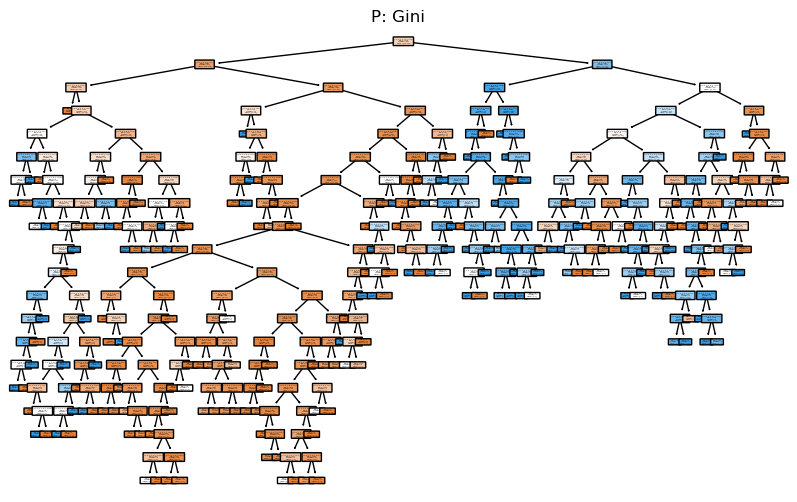

In [46]:
# O criterion gini é um dos criterions para avaliar o melhor atributo divisor para aquele nó.
# fixa a semente do gerador de números aleatórios, garantindo que os resultados sejam os 
# mesmos em cada execução do código.
clf1 = DecisionTreeClassifier(criterion='gini', random_state=0)

# Passamos os dados de treinamento e a verdade para o nosso modelo poder aprender fazendo 
# classificações corretas dos dados em x_train com base nos rotulos de y_train
clf1.fit(x_train, y_train)

# Aqui nós plotamos nosso gráfico
plt.figure(figsize=(10, 6))

# Passamos então o nome das features usadas no treinamento, como feature_names e dos rótulos usados para classificar
plot_tree(clf1, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.title("P: Gini")
plt.show()

In [47]:
# clf1 representa nossa hipótese treinada, vamos então usá-la no mundo real, ou seja, o teste
Y_pred1 = clf1.predict(X_test)

# Sabemos que a acurácia é o inverso do Error Rate, então nós basicamente 
# fazemos a média da quantia de erros de predição. 
# Porém, nós sabemos que a classe Not Survived possui mais  
balanced_accuracy_score(Y_test, Y_pred1)

0.8195488721804511

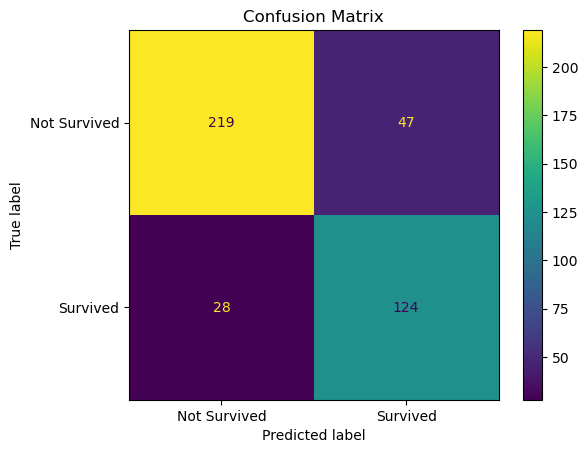

In [48]:
cm = confusion_matrix(Y_test, Y_pred1)

# Criar uma instância de ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived', 'Survived'])

# Plotar a matriz de confusão
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()

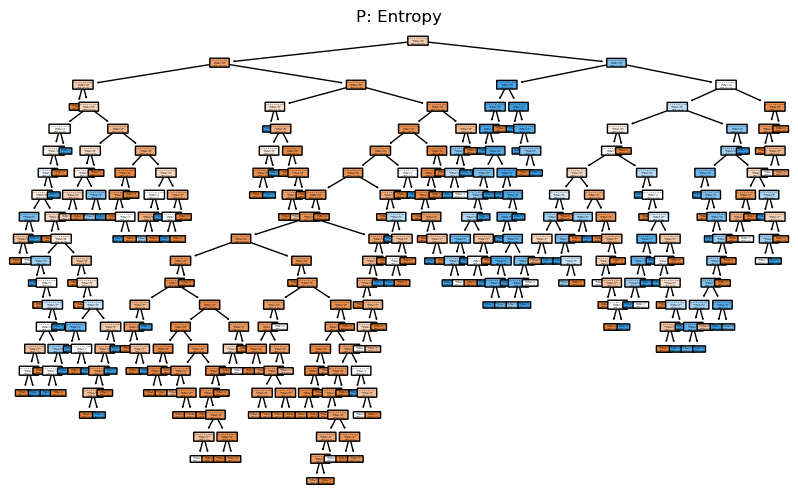

In [49]:
# Aqui nós estamos utilizando a entropia como método de escolha de atributos para divisão dos subconjuntos
clf2 = DecisionTreeClassifier(criterion='entropy', random_state=0)

# Iniciamos o aprendizado na base de treinamento
clf2.fit(x_train, y_train)

# Plotando usando Entropy
plt.figure(figsize=(10, 6))
plot_tree(clf2, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.title("P: Entropy")
plt.show()

In [50]:
Y_pred2 = clf2.predict(X_test)
balanced_accuracy_score(Y_test, Y_pred2)

0.8101503759398496

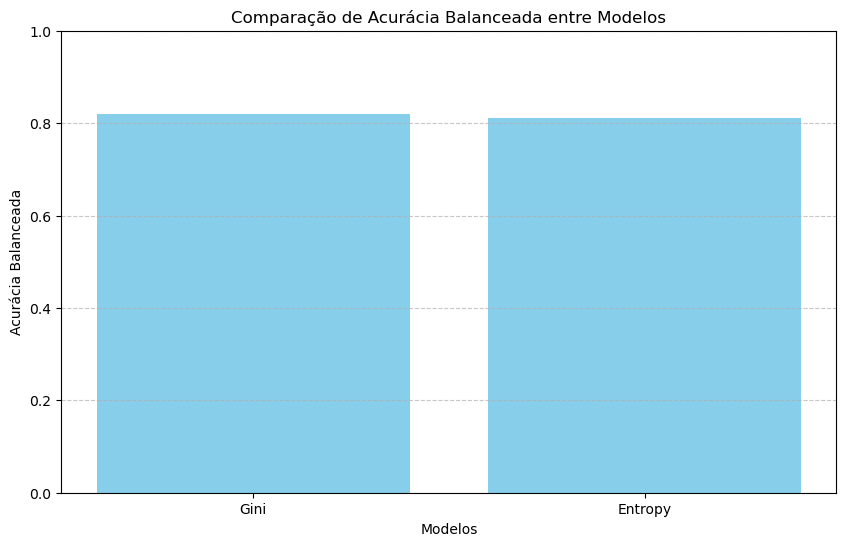

In [51]:
import matplotlib.pyplot as plt

modelos = ['Gini', 'Entropy']

# Acurácias balanceadas correspondentes
acuracias = [balanced_accuracy_score(Y_test, Y_pred1), balanced_accuracy_score(Y_test, Y_pred2)]  # Substitua pelos valores reais

# Plotagem do gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(modelos, acuracias, color='skyblue')
plt.xlabel('Modelos')
plt.ylabel('Acurácia Balanceada')
plt.title('Comparação de Acurácia Balanceada entre Modelos')
plt.ylim(0, 1)  # Definir o limite do eixo y de 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


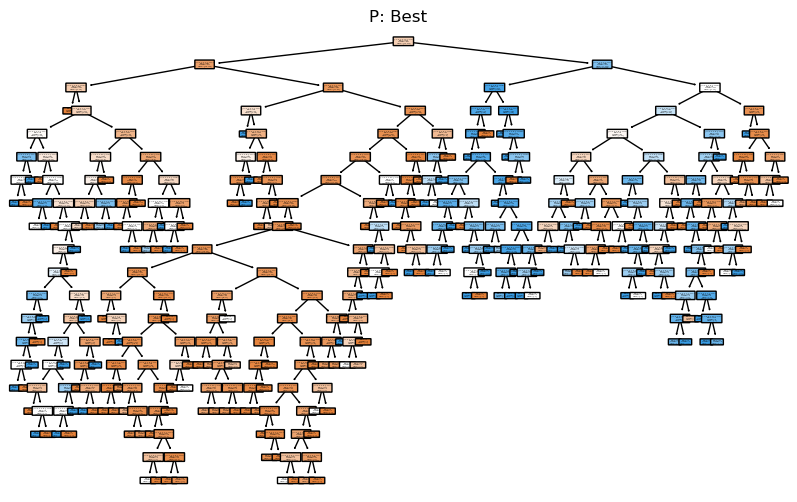

In [53]:
# O splitter best estabelece como critério de divisão a melhor divisão possível, 
# usando indice de gini ou redução maxima da variancia (para problemas de regressao)
clf3 = DecisionTreeClassifier(splitter='best', random_state=0)

# Fazemos o aprendizado no treinamento
clf3.fit(x_train, y_train)

# Plotamos a árvore
plt.figure(figsize=(10, 6))
plot_tree(clf3, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.title("P: Best")
plt.show()

In [54]:
# Aqui nós fazemos então a predição com base na hipótese
Y_pred3 = clf3.predict(X_test)

# Calculamos entao a acuracia balanceada
balanced_accuracy_score(Y_test, Y_pred3)

0.8195488721804511

**Obs:** Muito provavelmente, best usou indice de gini e por isso a acurácia saiu muito igual ao uso de criterion gini.

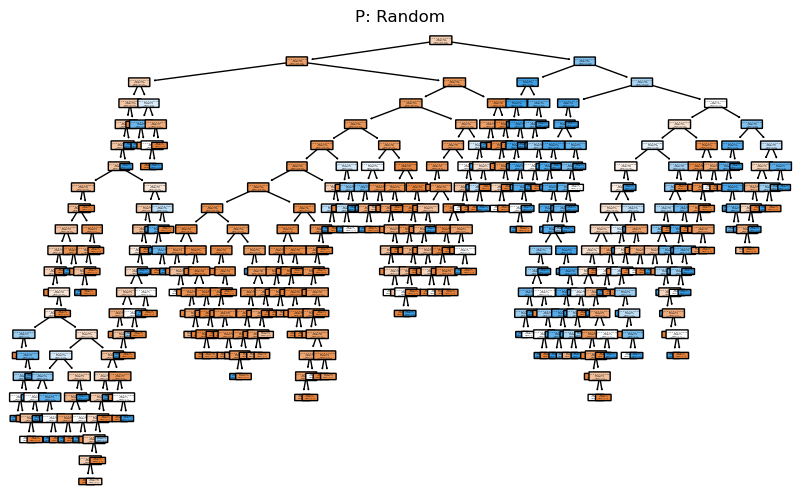

In [69]:
# O random utiliza alguma métrica de qualidade mínima como a redução minima de variância 
# ou o indice de gini para fazer as divisões dos subconjuntos 
clf4 = DecisionTreeClassifier(splitter='random', random_state=0)

# Aqui nós fazemos o aprendizado em treinamento
clf4.fit(x_train, y_train)

# Fazemos o plot da árvore
plt.figure(figsize=(10, 6))
plot_tree(clf4, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.title("P: Random")
plt.show()

In [70]:
Y_pred4 = clf4.predict(X_test)
balanced_accuracy_score(Y_test, Y_pred4)

0.8078007518796992

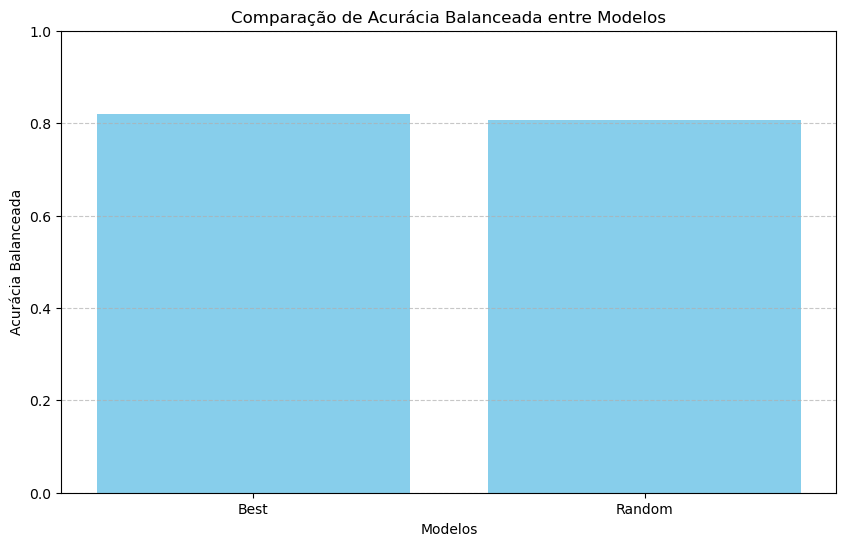

In [57]:
import matplotlib.pyplot as plt

modelos = ['Best', 'Random']

# Acurácias balanceadas correspondentes
acuracias = [balanced_accuracy_score(Y_test, Y_pred3), balanced_accuracy_score(Y_test, Y_pred4)]  # Substitua pelos valores reais

# Plotagem do gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(modelos, acuracias, color='skyblue')
plt.xlabel('Modelos')
plt.ylabel('Acurácia Balanceada')
plt.title('Comparação de Acurácia Balanceada entre Modelos')
plt.ylim(0, 1)  # Definir o limite do eixo y de 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


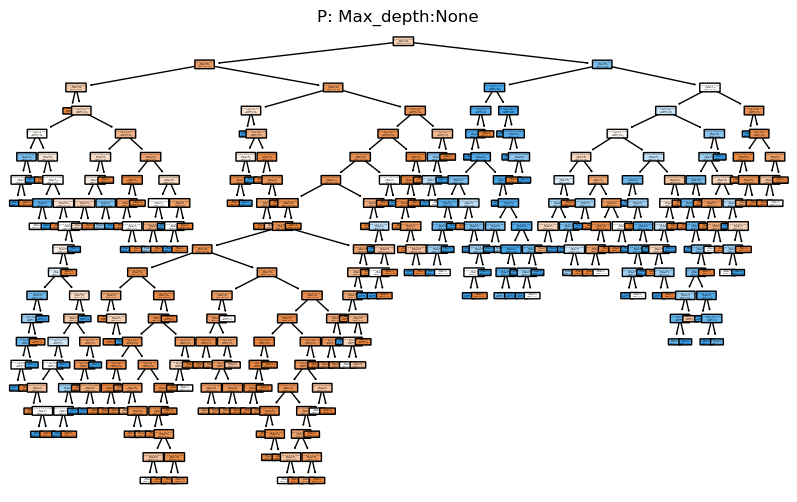

In [58]:
# Criamos um classificador de altura máxima indefinida
clf5 = DecisionTreeClassifier(max_depth=None, random_state=0)

# Fazemos o aprendizado em treinamento
clf5.fit(x_train, y_train)

# Fazemos a plotagem
plt.figure(figsize=(10, 6))
plot_tree(clf5, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.title("P: Max_depth:None")
plt.show()

In [59]:
Y_pred5 = clf5.predict(X_test)
balanced_accuracy_score(Y_test, Y_pred5)

0.8195488721804511

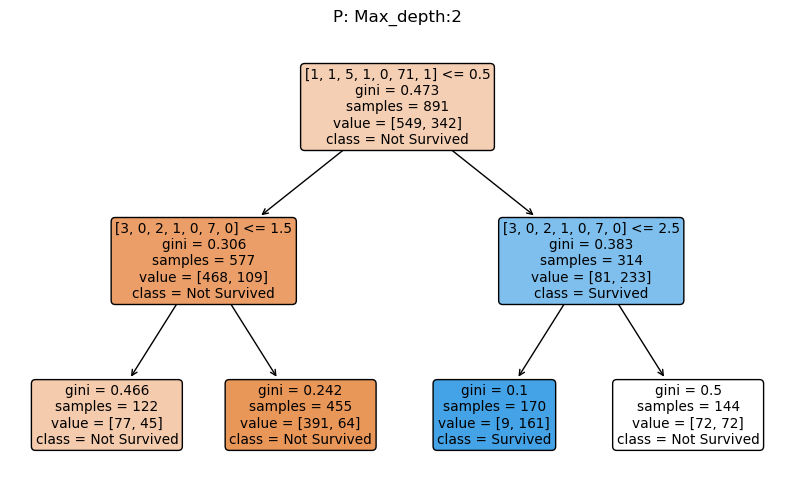

In [60]:
# Criamos então uma hipótese com profundidade de no máximo 2, ou seja, 3 nós de altura
clf6 = DecisionTreeClassifier(max_depth=2, random_state=0)

# Fazemos o aprendizado em treinamento
clf6.fit(x_train, y_train)

# Plotamos a árvore
plt.figure(figsize=(10, 6))
plot_tree(clf6, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.title("P: Max_depth:2")
plt.show()

In [71]:
Y_pred6 = clf6.predict(X_test)
balanced_accuracy_score(Y_test, Y_pred6)

0.763157894736842

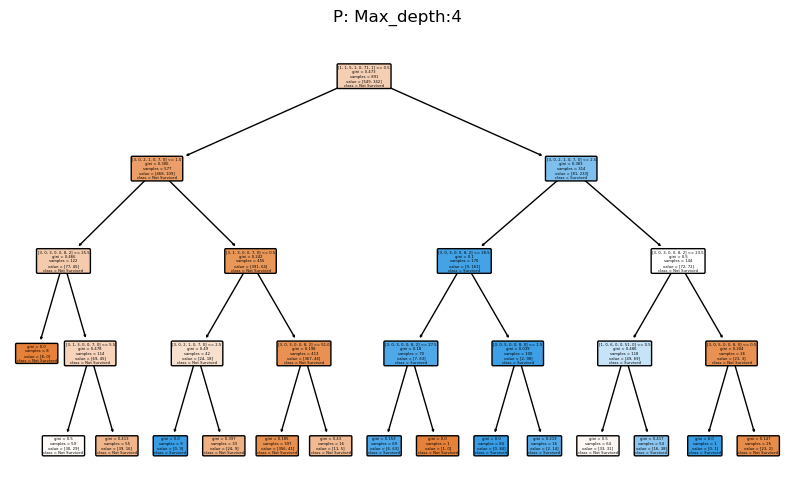

In [72]:
clf7 = DecisionTreeClassifier(max_depth=4, random_state=0)
clf7.fit(x_train, y_train)
plt.figure(figsize=(10, 6))
plot_tree(clf7, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.title("P: Max_depth:4")
plt.show()

In [73]:
Y_pred7 = clf7.predict(X_test)
balanced_accuracy_score(Y_test, Y_pred7)

0.8571428571428571

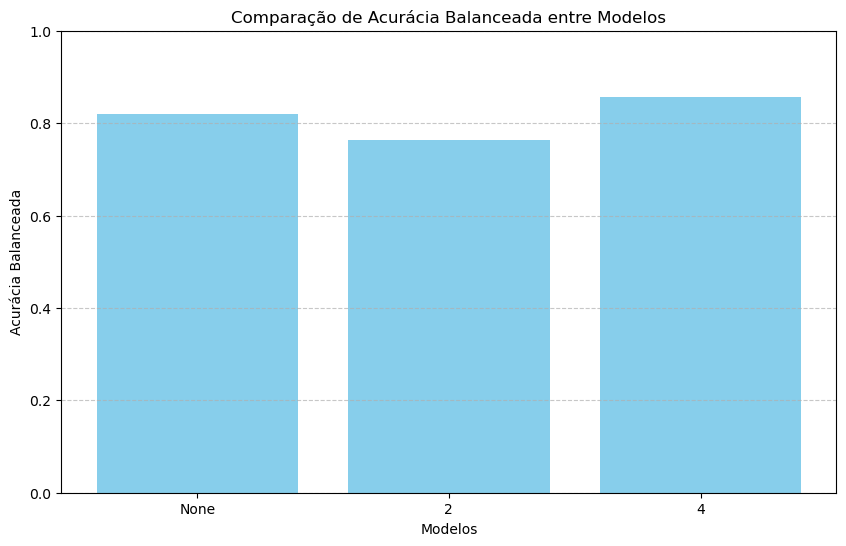

In [74]:
import matplotlib.pyplot as plt

modelos = ['None', '2', '4']

# Acurácias balanceadas correspondentes
acuracias = [balanced_accuracy_score(Y_test, Y_pred5), balanced_accuracy_score(Y_test, Y_pred6), balanced_accuracy_score(Y_test, Y_pred7)]  # Substitua pelos valores reais

# Plotagem do gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(modelos, acuracias, color='skyblue')
plt.xlabel('Modelos')
plt.ylabel('Acurácia Balanceada')
plt.title('Comparação de Acurácia Balanceada entre Modelos')
plt.ylim(0, 1)  # Definir o limite do eixo y de 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


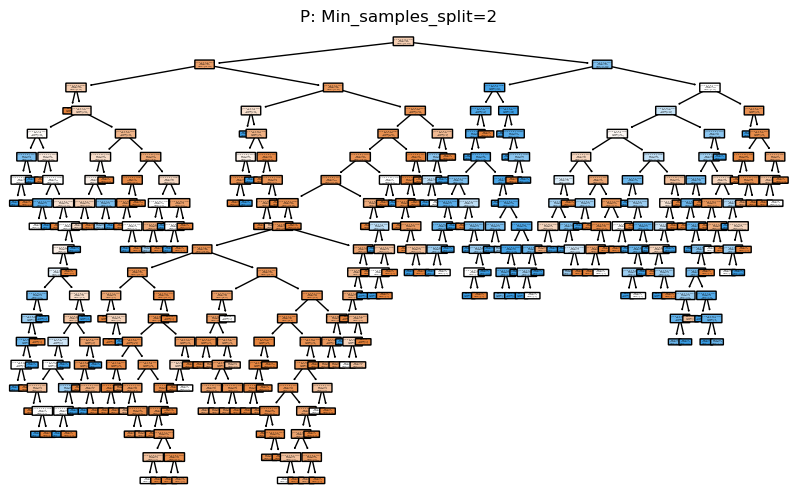

In [75]:
# Uma árvore de min sample split igual a 2 divide um subconjunto que contém pelo menos dois exemplos. 
# Aqui pode ocorrer overfitting, pois o ajuste excessivo pode complexar a hipotese.
clf8 = DecisionTreeClassifier(min_samples_split=2, random_state=0)
clf8.fit(x_train, y_train)
plt.figure(figsize=(10, 6))
plot_tree(clf8, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.title("P: Min_samples_split=2")
plt.show()

In [76]:
Y_pred8 = clf8.predict(X_test)
balanced_accuracy_score(Y_test, Y_pred8)

0.8195488721804511

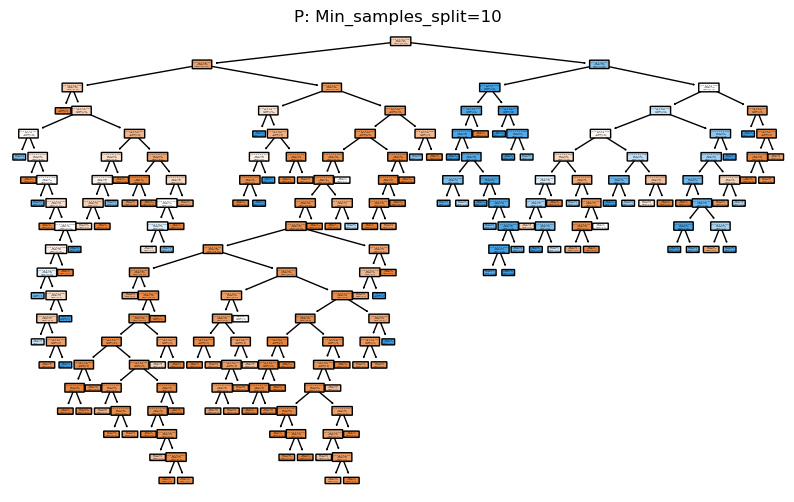

In [77]:
# Uma divisão feita com pelo menos 10 exemplos é capaz de gerar uma hipótese mais generalista, porém mais
# passiva de ocorrer underfitting
clf9 = DecisionTreeClassifier(min_samples_split=10, random_state=0)
clf9.fit(x_train, y_train)
plt.figure(figsize=(10, 6))
plot_tree(clf9, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.title("P: Min_samples_split=10")
plt.show()

In [78]:
Y_pred9 = clf9.predict(X_test)
balanced_accuracy_score(Y_test, Y_pred9)

0.8322368421052632

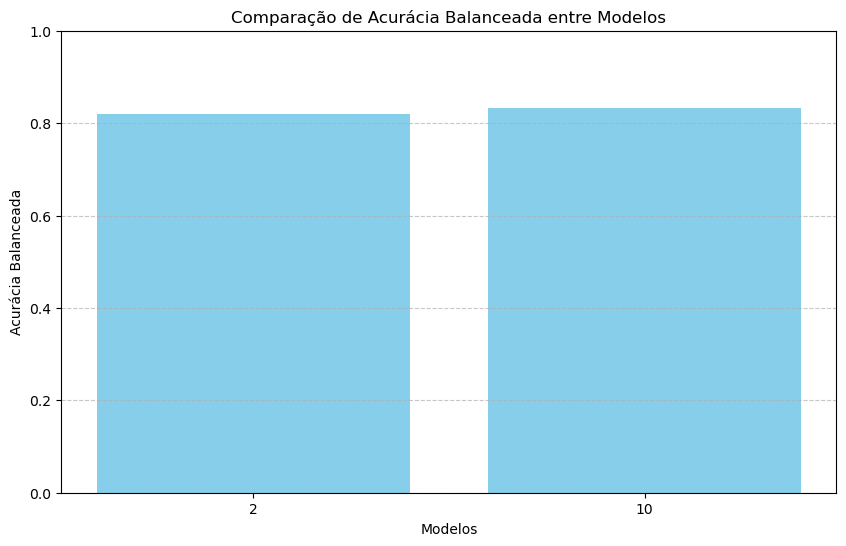

In [79]:
import matplotlib.pyplot as plt

modelos = ['2', '10']

# Acurácias balanceadas correspondentes
acuracias = [balanced_accuracy_score(Y_test, Y_pred8), balanced_accuracy_score(Y_test, Y_pred9)]  # Substitua pelos valores reais

# Plotagem do gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(modelos, acuracias, color='skyblue')
plt.xlabel('Modelos')
plt.ylabel('Acurácia Balanceada')
plt.title('Comparação de Acurácia Balanceada entre Modelos')
plt.ylim(0, 1)  # Definir o limite do eixo y de 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
